# Lab03: Custom GRU for Text Generation

In this lab, you will build a sequence-to-sequence model for text generation.  

# Introduction to Sequence-to-Sequence (Seq2Seq) Models

Sequence-to-Sequence (Seq2Seq) models are a class of neural networks designed to map an input sequence to an output sequence, even when the two sequences have different lengths. They are widely used in applications such as machine translation, text summarization, dialogue systems, and text generation.

## Key Components

### Encoder

The **encoder** processes the entire input sequence (for example, a sentence or a series of tokens) one token at a time. Typically implemented using recurrent neural networks (RNNs) such as GRU or LSTM, the encoder compresses the input into a fixed-dimensional vector, often referred to as the **context vector** or **hidden state**. This vector is intended to capture the semantic and syntactic information of the input sequence.

### Decoder

The **decoder** takes the context vector produced by the encoder and generates the output sequence one token at a time. Also implemented as an RNN, the decoder uses the context vector to initialize its hidden state and then generates an output token. It uses its previous output (or a combination of that output and the context) to predict the next token, repeating this process until an end-of-sequence token is produced.

## How It Works

1. **Encoding the Input:**
   - The encoder processes the input sequence \( \{x_1, x_2, \ldots, x_T\} \) and updates its hidden state at each time step.
   - The final hidden state \( h_T \) (or a combination of hidden states) is used as a summary of the input.

2. **Decoding the Output:**
   - The decoder initializes its hidden state using the context vector \( h_T \).
   - It then generates the output sequence \( \{y_1, y_2, \ldots, y_{T'}\} \) by predicting one token at a time.
   - At each decoding step, the decoder uses its current hidden state and possibly the previous token to predict the next token.

3. **Handling Variable Lengths:**
   - Because both the encoder and decoder are recurrent, they can process sequences of variable lengths. This flexibility makes Seq2Seq models effective for many different tasks.


## Task

You will train the model on a sample text  
corpus and generate text from the trained model.

The GRU cell is defined with the following equations:

  rₜ = σ(Wᵣ xₜ + Uᵣ hₜ₋₁)  
  zₜ = σ(W_z xₜ + U_z hₜ₋₁)  
  nₜ = tanh(Wₙ xₜ + Uₙ (rₜ ⊙ hₜ₋₁))  
  hₜ = (1 - zₜ) ⊙ nₜ + zₜ ⊙ hₜ₋₁ + tanh(W_res xₜ)

The Encoder uses a standard multi-layer GRU:

  hₜ = GRU(xₜ, hₜ₋₁)

The Decoder processes one token at a time using a stack of custom GRU cells.  
The final output is generated as:

  yₜ = W_out hₜ

*Prepared by Ziming Liu*


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


# 1. Data Preprocessing

In [5]:

# Sample text from Shakespeare (demonstration corpus)
text = (
    "To be, or not to be, that is the question: "
    "Whether 'tis nobler in the mind to suffer "
    "The slings and arrows of outrageous fortune, "
    "Or to take arms against a sea of troubles, "
    "And by opposing end them. To die: to sleep; "
    "No more; and by a sleep to say we end "
    "The heart-ache and the thousand natural shocks "
    "That flesh is heir to, 'tis a consummation "
    "Devoutly to be wish'd. To die, to sleep; "
)

# Create a character-level vocabulary
chars = sorted(list(set(text)))
vocab_size = len(chars)
char2idx = {ch: i for i, ch in enumerate(chars)}
idx2char = {i: ch for i, ch in enumerate(chars)}

# Convert the entire text into integer indices
data = [char2idx[ch] for ch in text]
print(data)
print(char2idx)
print(idx2char)

# Set sequence length and create training examples (input, target pairs)
seq_length = 40
step = 1
input_sequences = []
target_sequences = []

##########################################
# Your code starts here.

# generate the sentense pairs of seq_length
for i in range(0, len(data) - seq_length, step):
    inp_seq = data[i: i + seq_length]
    target_seq = data[i + 1: i + seq_length + 1]
    input_sequences.append(inp_seq)
    target_sequences.append(target_seq)


# Your code ends here.
##########################################
print(f"Number of sequences: {len(input_sequences)}")

# Convert lists to tensors
input_tensor = torch.tensor(input_sequences, dtype=torch.long)
target_tensor = torch.tensor(target_sequences, dtype=torch.long)


[11, 26, 0, 14, 17, 2, 0, 26, 29, 0, 25, 26, 31, 0, 31, 26, 0, 14, 17, 2, 0, 31, 20, 13, 31, 0, 21, 30, 0, 31, 20, 17, 0, 28, 32, 17, 30, 31, 21, 26, 25, 5, 0, 12, 20, 17, 31, 20, 17, 29, 0, 1, 31, 21, 30, 0, 25, 26, 14, 23, 17, 29, 0, 21, 25, 0, 31, 20, 17, 0, 24, 21, 25, 16, 0, 31, 26, 0, 30, 32, 18, 18, 17, 29, 0, 11, 20, 17, 0, 30, 23, 21, 25, 19, 30, 0, 13, 25, 16, 0, 13, 29, 29, 26, 34, 30, 0, 26, 18, 0, 26, 32, 31, 29, 13, 19, 17, 26, 32, 30, 0, 18, 26, 29, 31, 32, 25, 17, 2, 0, 10, 29, 0, 31, 26, 0, 31, 13, 22, 17, 0, 13, 29, 24, 30, 0, 13, 19, 13, 21, 25, 30, 31, 0, 13, 0, 30, 17, 13, 0, 26, 18, 0, 31, 29, 26, 32, 14, 23, 17, 30, 2, 0, 7, 25, 16, 0, 14, 35, 0, 26, 27, 27, 26, 30, 21, 25, 19, 0, 17, 25, 16, 0, 31, 20, 17, 24, 4, 0, 11, 26, 0, 16, 21, 17, 5, 0, 31, 26, 0, 30, 23, 17, 17, 27, 6, 0, 9, 26, 0, 24, 26, 29, 17, 6, 0, 13, 25, 16, 0, 14, 35, 0, 13, 0, 30, 23, 17, 17, 27, 0, 31, 26, 0, 30, 13, 35, 0, 34, 17, 0, 17, 25, 16, 0, 11, 20, 17, 0, 20, 17, 13, 29, 31, 3, 13, 15

# 2. Model Definitions

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Encoder: A multi-layer GRU encoder that processes the input sequence.
# The GRU computes: h_t = GRU(x_t, h_{t-1})
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, num_layers, dropout=0.2)

    def forward(self, src):
        # src shape: (seq_len, batch_size)
        # Embedded input: x_t
        embedded = self.embedding(src)
        # GRU computes h_t from x_t and previous hidden state: h_t = GRU(x_t, h_{t-1})
        outputs, hidden = self.gru(embedded)
        # outputs: (seq_len, batch, hidden)
        return outputs, hidden

# Custom GRU Cell with a residual connection from the input.
# Equations:
#   r_t = σ(W_r x_t + U_r h_{t-1})
#   z_t = σ(W_z x_t + U_z h_{t-1})
#   n_t = tanh(W_n x_t + U_n (r_t ⊙ h_{t-1}))
#   h_t = (1 - z_t) ⊙ n_t + z_t ⊙ h_{t-1} + tanh(W_res x_t)
class CustomGRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CustomGRUCell, self).__init__()
        self.hidden_size = hidden_size

        ##########################################
        # Your code starts here.

        # Reset gate parameters with no bias
        self.W_r = nn.Linear(input_size, hidden_size)
        self.U_r = nn.Linear(hidden_size, hidden_size)

        # Update gate parameters with no bias
        self.W_z = nn.Linear(input_size, hidden_size)
        self.U_z = nn.Linear(hidden_size, hidden_size)

        # Candidate hidden state parameters
        self.W_n = nn.Linear(input_size, hidden_size)
        self.U_n = nn.Linear(hidden_size, hidden_size)

        # Residual connection transformation
        self.W_res = nn.Linear(input_size, hidden_size)
        # Your code ends here.
        ##########################################

    def forward(self, x, h):

        ##########################################
        # Your code starts here.
        # x: (batch, input_size), h: (batch, hidden_size)
        # Compute reset gate: r_t = σ(W_r x_t + U_r h_{t-1})
        r = torch.sigmoid(self.W_r(x) + self.U_r(h) )
        # Compute update gate: z_t = σ(W_z x_t + U_z h_{t-1})
        z = torch.sigmoid(self.W_z(x) + self.U_z(h) )
        # Compute candidate hidden state: n_t = tanh(W_n x_t + U_n (r_t ⊙ h_{t-1}))
        n = torch.tanh(self.W_n(x) + self.U_n(r * h))
        # Residual connection: transform x and add to the new state
        res = torch.tanh(self.W_res(x))
        # Compute new hidden state: h_t = (1 - z_t) ⊙ n_t + z_t ⊙ h_{t-1} + tanh(W_res x_t)
        h_new = (1 - z) * n + z * h + res
        # Your code ends here.
        ##########################################
        return h_new

# Decoder: A multi-layer decoder that uses a stack of custom GRU cells.
# For each layer, the custom GRU cell processes the input as defined above.
# The final output is computed as: y_t = W_out h_t
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.num_layers = num_layers
        ##########################################
        # Your code starts here.
        # Create custom GRU cells for each layer
        # this is wrong
        # self.custom_cells = nn.ModuleList([CustomGRUCell(embed_size, hidden_size) 
        # for _ in range(num_layers)

        # ])

        self.custom_cells = nn.ModuleList([
            CustomGRUCell(embed_size if i == 0 else hidden_size, hidden_size)
            for i in range(num_layers)
        ])
        # Your code ends here.
        ##########################################
        self.fc_out = nn.Linear(hidden_size, vocab_size)

    def forward(self, input, hidden):
        # input: (batch) token indices; embed to (batch, embed_size)
        embedded = self.embedding(input)
        new_hidden = []
        x = embedded
        # Pass input through each custom GRU cell sequentially
        for i, cell in enumerate(self.custom_cells):
            h = hidden[i]
            h_new = cell(x, h)
            new_hidden.append(h_new)
            x = h_new  # The output of one layer is the input to the next
        new_hidden = torch.stack(new_hidden, dim=0)  # (num_layers, batch, hidden)
        # Compute the final output token logits: y_t = W_out h_t
        output = self.fc_out(x)
        return output, new_hidden

# Seq2Seq Model: Combines the Encoder and Decoder.
# The model generates the output sequence token by token.
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg):
        # src: (seq_len, batch), trg: (seq_len, batch)
        batch_size = src.size(1)
        trg_len = trg.size(0)
        vocab_size = self.decoder.fc_out.out_features

        outputs = torch.zeros(trg_len, batch_size, vocab_size).to(self.device)

        # Encode the input sequence: h_t = GRU(x_t, h_{t-1})
        encoder_outputs, hidden = self.encoder(src)

        # The first input token to the decoder is the first token of the target sequence
        input_dec = trg[0, :]

        ##########################################
        # Your code starts here.
        # Generate the output sequence token by token
        for t in range(1, trg_len):
            output, hidden = self.decoder(input_dec, hidden)
            outputs[t] = output
            # Use the highest scoring token as the next input
            top1 = output.argmax(1)
            input_dec = top1
        # Your code ends here.
        ##########################################

        return outputs


# 3. Training

Dataset size: 346
Epoch 1/50 - Loss: 3.5145
Epoch 2/50 - Loss: 3.0886
Epoch 3/50 - Loss: 2.9881
Epoch 4/50 - Loss: 2.9677
Epoch 5/50 - Loss: 2.9523
Epoch 6/50 - Loss: 2.9380
Epoch 7/50 - Loss: 2.9353
Epoch 8/50 - Loss: 2.9069
Epoch 9/50 - Loss: 2.9061
Epoch 10/50 - Loss: 2.8907
Epoch 11/50 - Loss: 2.8726
Epoch 12/50 - Loss: 2.8369
Epoch 13/50 - Loss: 2.8573
Epoch 14/50 - Loss: 2.8037
Epoch 15/50 - Loss: 2.7933
Epoch 16/50 - Loss: 2.7434
Epoch 17/50 - Loss: 2.7388
Epoch 18/50 - Loss: 2.6902
Epoch 19/50 - Loss: 2.6985
Epoch 20/50 - Loss: 2.6477
Epoch 21/50 - Loss: 2.5733
Epoch 22/50 - Loss: 2.5125
Epoch 23/50 - Loss: 2.3731
Epoch 24/50 - Loss: 2.1351
Epoch 25/50 - Loss: 1.7371
Epoch 26/50 - Loss: 1.5792
Epoch 27/50 - Loss: 1.3312
Epoch 28/50 - Loss: 0.9279
Epoch 29/50 - Loss: 0.5890
Epoch 30/50 - Loss: 0.4207
Epoch 31/50 - Loss: 0.0841
Epoch 32/50 - Loss: 0.1226
Epoch 33/50 - Loss: 0.0575
Epoch 34/50 - Loss: 0.0726
Epoch 35/50 - Loss: 0.0102
Epoch 36/50 - Loss: 0.0062
Epoch 37/50 - Loss:

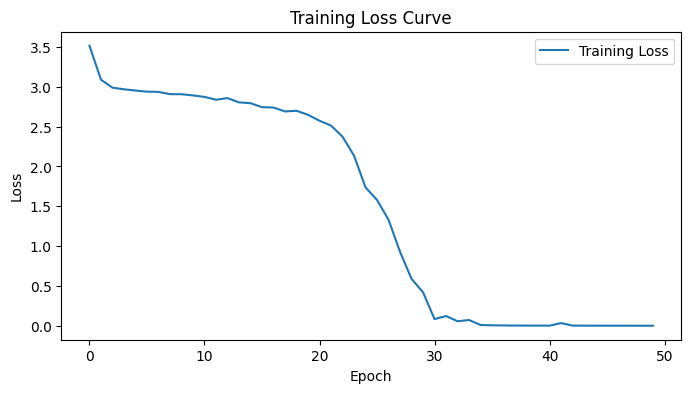

In [7]:
# Takes a bit more than 1 min on Google Colab T4 GPU


# Hyperparameters
embed_size = 64
hidden_size = 128
num_layers = 2
num_epochs = 50
learning_rate = 0.005
batch_size = 32

dataset_size = input_tensor.size(0)
print("Dataset size:", dataset_size)

# Initialize the Encoder, Decoder, and the Seq2Seq model
encoder = Encoder(vocab_size, embed_size, hidden_size, num_layers).to(device)
decoder = Decoder(vocab_size, embed_size, hidden_size, num_layers).to(device)
model = Seq2Seq(encoder, decoder, device).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Function to generate random mini-batches from the training data
def get_batch(batch_size):
    indices = np.random.choice(dataset_size, batch_size)
    src = input_tensor[indices].t().to(device)   # (seq_len, batch)
    trg = target_tensor[indices].t().to(device)    # (seq_len, batch)
    return src, trg


# The training loop applies gradient clipping to stabilize training.
all_losses = []

for epoch in range(1, num_epochs + 1):
    model.train()
    epoch_loss = 0
    num_batches = max(1, dataset_size // batch_size)

    for _ in range(num_batches):
        src, trg = get_batch(batch_size)
        optimizer.zero_grad()
        output = model(src, trg)
        # Reshape output for loss computation
        output_dim = output.shape[-1]
        output = output[1:].reshape(-1, output_dim)  # Ignore the first token
        trg_loss = trg[1:].reshape(-1)

        loss = criterion(output, trg_loss)
        loss.backward()

        # Apply gradient clipping to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / num_batches
    all_losses.append(avg_loss)
    print(f"Epoch {epoch}/{num_epochs} - Loss: {avg_loss:.4f}")

# Plot the training loss curve over epochs
plt.figure(figsize=(8, 4))
plt.plot(all_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()


# 4. Text Generation

In [8]:
# --------------------------
# 5. Text Generation
# --------------------------
# This function generates text using the trained model starting from a given string.
def generate_text(model, start_str, gen_length=200, temperature=1.0):
    model.eval()
    input_seq = [char2idx[ch] for ch in start_str]
    input_tensor_gen = torch.tensor(input_seq, dtype=torch.long).unsqueeze(1).to(device)  # (seq_len, 1)

    # Encode the input sequence
    encoder_outputs, hidden = encoder(input_tensor_gen)

    # Use the last character of the input as the first token for the decoder
    input_dec = input_tensor_gen[-1, :]
    generated = start_str

    for _ in range(gen_length):
        output, hidden = decoder(input_dec, hidden)
        # Apply temperature sampling to control randomness in generation
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        char = idx2char[top_i.item()]
        generated += char
        input_dec = torch.tensor([top_i.item()]).to(device)

    return generated

# Generate and display sample text from the trained model
start_string = "To be"
generated_text = generate_text(model, start_string, gen_length=300, temperature=0.8)
print("\nGenerated Text:\n")
print(generated_text)



Generated Text:

To be, to say we end The heart-ache and the thousand natural shocks That flesh is heir to, 'tis a consummation Devoutly to be wish'd. To die, to sleep; No more; and by a sleep to say we end The heart-ache and the thousand natural shocks That flesh is heir to, 'tis a consummation Devoutly to be wish'd. To
